In [49]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
np.set_printoptions(precision=4)

In [51]:
# g === area (big image) -- from RIGHT img (#2)
# f === fragment -- from LEFT img (#1)

f = Image.open("img/20160825-143207-156-1_aff_applied.png").convert('L')

BIG_WIDTH = f.width

# Get fragment from left image
wf = 100
hf = 100

xf = np.random.randint(f.width / 4.0, 3 * f.width / 4.0)
yf = np.random.randint(f.height / 4.0, 3 * f.height / 4.0)

crop_box = (xf, yf, xf + wf, yf + hf)
f = f.crop(crop_box)

f_mat = np.asarray(f.getdata(), dtype=np.int8).reshape(f.size[1], f.size[0])
print f.size
print yf, xf

(100, 100)
1225 1434


In [52]:
# typical Other settings: 
settings = [17, 0.5, 62, 5, 256, 200]

base = settings[0]
base_err = settings[1]
viewangle_x = settings[2] # in degrees
viewangle_x_err = settings[3] # in degrees
num_shades = int(settings[4])
min_height = settings[5]

resolution_x = BIG_WIDTH;
viewangle = np.pi * viewangle_x / 180.0

In [53]:
# g === area (big image) -- from RIGHT img (#2)
# f === fragment -- from LEFT img (#1)
g = Image.open('img/20160825-143207-156-2_aff_applied.png').convert('L')

# mpd is Maximum Pixel Distance <--> Minimum cloud height(altitude)
mpd = base * resolution_x / (2 * np.tan(viewangle / 2.0) * min_height)
fac_x = 1; # reserve-coefficient
fac_y = 2; #reserve-coefficient

area_x = int(xf - fac_x * wf)
area_y = int(yf - fac_y * hf)
area_width = int(mpd + 2 * fac_x * wf)
area_height = int(2 * fac_y * hf)
print area_x, area_y
print area_width, area_height

# area to search on right image
g = g.crop( (area_x, area_y, 
                        area_x + area_width, area_y + area_height) ) 

wg = area_width
hg = area_height
xg = area_x
yg = area_y

1334 1025
398 400


In [54]:
print g.size
g_mat = np.asarray(g.getdata(), dtype=np.int8).reshape(g.size[1], g.size[0])

(398, 400)


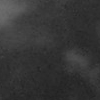

In [55]:
f

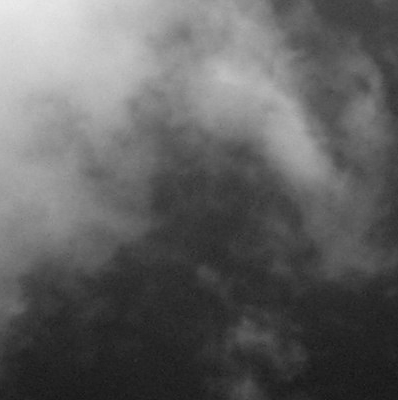

In [56]:
g

In [57]:
# difference == gfrag - f
diff = np.zeros((g.size[1] - f.size[1], g.size[0] -f.size[0]), dtype=int)

In [58]:
for h in xrange(g.size[1] - f.size[1]):
    for w in xrange(g.size[0] - f.size[0]):
        if h % 5 == 0:
            print '\r h:', h,
        
        diff[h, w] = ( abs(g_mat[h : h + hf, w : w + wf] - f_mat) ).sum()
        

 h: 295


64200
Left: 1225 1434
Right: 1240 1464


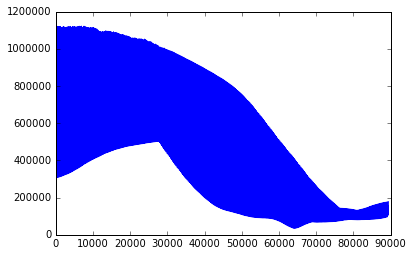

In [59]:
plt.plot(diff.ravel())
idx_min = diff.argmin()
print idx_min

print 'Left:', yf, xf
y_found, x_found = idx_min // diff.shape[1], idx_min % diff.shape[1]
print 'Right:', y_found + yg, x_found + xg

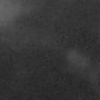

In [60]:
Image.fromarray(g_mat[y_found : y_found + hf, x_found : x_found + wf], 'L')

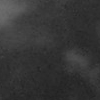

In [61]:
f

In [62]:
# result x, y -- координаты кусочка, найденного в области поиска g
res_y, res_x = y_found + yg, x_found + xg

In [63]:
# Calculate altitude
x_pixel_distance = abs(res_x - xf)
viewangle = np.pi * viewangle_x / 180.0;
altitude = base * resolution_x / (2 * np.tan(viewangle / 2.0) * x_pixel_distance)
resolution_x_err = 2; #pixels

err_distance = base_err * resolution_x / ( 2 * np.tan(viewangle / 2.0) * x_pixel_distance )

err_viewangle = (viewangle_x_err * np.pi / 180.0) * ( base * resolution_x / \
                                                   (4.0 * x_pixel_distance * (np.sin(viewangle / 2.0)) ** 2) )

err_resolution = resolution_x_err * base * resolution_x / \
                    ( 2 * np.tan(viewangle / 2.0) * (x_pixel_distance) ** 2 ) 

total_error = np.sqrt( err_distance ** 2 + err_viewangle ** 2 + err_resolution ** 2 )
ratio_error = total_error * 100.0 / altitude


print "Search done"
print "Pixel distance:", x_pixel_distance
print "Altitude: %f +- %f meters (error is %f percent)" % (altitude, total_error, ratio_error)

Search done
Pixel distance: 30
Altitude: 1325.515394 +- 162.762977 meters (error is 12.279222 percent)


In [64]:
with open('results/20160825-143207-156.txt', mode='a') as f:
    s = str(x_pixel_distance) + ' ' + str(altitude) + ' ' + \
        str(total_error) + '\n'
    f.write(s)
    